# Exploratory analysis of Rental-Crawl.xlsx real estate data

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%config InlineBackend.figure_format = 'retina'

In [2]:
import os
import time

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl

import numpy as np
np.set_printoptions(precision=2, linewidth=120, suppress=True, edgeitems=4)

import pandas as pd
from pandas import ExcelFile

pd.set_option('display.max_columns', 350)
pd.set_option('display.max_rows', 150)

#pd.set_option('precision', 5)

import nltk
from nltk.util import ngrams
from collections import Counter
from nltk.corpus import stopwords
import string
stopWords = stopwords.words('english') + list(string.punctuation)

from nltk.probability import FreqDist
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim

In [ ]:
from sklearn.model_selection import KFold,train_test_split,StratifiedKFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor,RandomizedLasso
from sklearn.feature_selection import RFE, f_regression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.feature_selection import RFE, RFECV

In [3]:
#os.getcwd()
#!ls
os.chdir('/Users/zacklarsen/Dropbox/Datasets/')
!ls

AssessorCSV.csv                       Icon?
Axiometrics Trends.xlsx               Int%2FExt Attribute Example (1).xlsx
CA 2.txt                              RCA Data Sample.xls
CA.txt                                Real Capital Analytics Sample.xls
Chuckor_Assessor_Layout_20161103.xlsx Rent Zip Map.xlsx
Deed_CA.txt.zip                       Rental Crawl Sample.xlsx
FirstAmListing.txt


In [4]:
RentCrawl = pd.read_excel('Rental Crawl Sample.xlsx',header=None)
RentCrawl.columns = ['Name','Address','Description','Bedrooms','Bathrooms','SqFt','Rent',
                                                   'Bedrooms2','Bathrooms2','SqFt2','Rent2']
#RentCrawl.head(2)

In [5]:
# Use Regex to parse the address and zip code and city
# Also, do same to remove text from bedrooms and bathrooms and sqft to strip down to just numerical values
zips = []

import re
regex= re.compile(r"(?:\b[9]\d{4})")

for row in RentCrawl.Address:
    Zip= re.findall(regex, row)
    #zips.append(Zip)
    
    try:
        zips.append(Zip[0].encode("UTF-8"))
    
    except:   
        zips.append('missing')    
        
# print(zips)

RentCrawl['ZIP'] = zips
RentCrawl = RentCrawl.iloc[:,[0,1,11,2,3,4,5,6,7,8,9,10]]

In [6]:
RentCrawl.head(1)

,Name,Address,ZIP,Description,Bedrooms,Bathrooms,SqFt,Rent,Bedrooms2,Bathrooms2,SqFt2,Rent2
0,Rental Apartment 245 N. Alvarado St. (2 2) Los...,CA 90026 Los Angeles,90026,2 BEDROOM + 2 BATHROOM Modern / Controlled Acc...,2 Bed room,2 Bath room,"1,000 sq . ft",1700,NaN,NaN,NaN,NaN


In [7]:
url = 'https://raw.githubusercontent.com/grammakov/USA-cities-and-states/master/us_cities_states_counties.csv'
counties=pd.read_csv(url,sep='|')

towns = counties[counties['State short'] == 'CA']['City alias'].values
towns = [x.lower() for x in towns]
#towns



cities = []

for row in RentCrawl.Address:
    st = row.encode("UTF8").lower()
    try:
        City = [e.strip() for e in st.split(',')][1]
        #print(City)        
        if City in towns:
            cities.append(City)
        else:
            cities.append('NaN')
    
    except:
        cities.append('NaN')
    
            
#cities


RentCrawl['City'] = cities
RentCrawl = RentCrawl.iloc[:,[0,1,2,12,3,4,5,6,7,8,9,10,11]]

In [8]:
#RentCrawl.head(3)

In [9]:
# This is to remove values where the lessor has not provided a rent price
RentCrawl['Rent']= np.where(RentCrawl['Rent'] == 'Ask', 'Nan', RentCrawl['Rent']) 
#RentCrawl.head(3)

In [10]:
RentCrawl = RentCrawl[RentCrawl['Rent'].notnull()]
RentCrawl = RentCrawl[RentCrawl['Rent'] != 'Nan']

In [72]:
# This is only to be run if we really want to remove rows not having an entry for SqFt. This
# considerably reduces the size of the dataset

#RentCrawl = RentCrawl[RentCrawl['SqFt'].notnull()]
#RentCrawl = RentCrawl[RentCrawl['SqFt'] != 'Nan']

In [11]:
descriptions = []

for i in RentCrawl.Description:
    try:
        #print(i.encode("UTF8").lower())
        descriptions.append(i.encode("UTF8").lower())
    except:
        pass
        #print(i)
        #descriptions.append(i)
        
#descriptions[:10]
       

In [12]:
descriptions[0]

'2 bedroom + 2 bathroom modern / controlled access building prime echo park location near silverlake easy access to hollywood downtown...'

In [13]:
sentence_list = []

for description in descriptions:
    sentences = nltk.sent_tokenize(description)
    sentences = [nltk.word_tokenize(sent) for sent in sentences]
    sentences = [nltk.pos_tag(sent) for sent in sentences]
    sentence_list.append(sentences)
    #print(sentences)

In [14]:
sentence_list[3]

[[('2', 'CD'),
  ('bedroom', 'NN'),
  ('+', 'NN'),
  ('1.75', 'CD'),
  ('bath', 'NN'),
  ('hardwood', 'NN'),
  ('floors', 'NNS'),
  ('carpet', 'VBP'),
  ('front/upper', 'JJ'),
  ('unit', 'NN'),
  ('lots', 'NNS'),
  ('of', 'IN'),
  ('sunlight', 'JJ'),
  ('1', 'CD'),
  ('reserved', 'VBD'),
  ('parking', 'VBG'),
  ('space', 'NN'),
  ('prime', 'JJ'),
  ('koreatown', 'NN'),
  ('...', ':')]]

In [15]:
# Chunking:

grammar = "NP: {<DT>?<JJ>*<NN>}" 
cp = nltk.RegexpParser(grammar)
result = cp.parse(sentence_list[3][0])

for i in result:
    print(i)

('2', 'CD')
(NP bedroom/NN)
(NP +/NN)
('1.75', 'CD')
(NP bath/NN)
(NP hardwood/NN)
('floors', 'NNS')
('carpet', 'VBP')
(NP front/upper/JJ unit/NN)
('lots', 'NNS')
('of', 'IN')
('sunlight', 'JJ')
('1', 'CD')
('reserved', 'VBD')
('parking', 'VBG')
(NP space/NN)
(NP prime/JJ koreatown/NN)
('...', ':')


In [18]:
# Unigrams

for description in descriptions[:10]:
    sentences = nltk.sent_tokenize(description)
    sentences = [nltk.word_tokenize(sent) for sent in sentences]
    trigrams = ngrams(sentences[0],3)

    print Counter(trigrams)

Counter({('modern', '/', 'controlled'): 1, ('2', 'bathroom', 'modern'): 1, ('location', 'near', 'silverlake'): 1, ('access', 'building', 'prime'): 1, ('access', 'to', 'hollywood'): 1, ('bathroom', 'modern', '/'): 1, ('silverlake', 'easy', 'access'): 1, ('+', '2', 'bathroom'): 1, ('echo', 'park', 'location'): 1, ('hollywood', 'downtown', '...'): 1, ('prime', 'echo', 'park'): 1, ('to', 'hollywood', 'downtown'): 1, ('bedroom', '+', '2'): 1, ('controlled', 'access', 'building'): 1, ('park', 'location', 'near'): 1, ('building', 'prime', 'echo'): 1, ('2', 'bedroom', '+'): 1, ('easy', 'access', 'to'): 1, ('near', 'silverlake', 'easy'): 1, ('/', 'controlled', 'access'): 1})
Counter({('modern', '/', 'controlled'): 1, ('2', 'bathroom', 'modern'): 1, ('location', 'near', 'silverlake'): 1, ('access', 'building', 'prime'): 1, ('access', 'to', 'hollywood'): 1, ('bathroom', 'modern', '/'): 1, ('silverlake', 'easy', 'access'): 1, ('+', '2', 'bathroom'): 1, ('echo', 'park', 'location'): 1, ('hollywood'

In [19]:
stopWords = set(stopWords)

termlist = []

for description in descriptions:
    sentences = nltk.sent_tokenize(description)
    sentences = [nltk.word_tokenize(sent) for sent in sentences]
    for term in sentences[0]:
        if term not in stopWords:
            termlist.append(term)

In [20]:
termlist[:10]

['2',
 'bedroom',
 '2',
 'bathroom',
 'modern',
 'controlled',
 'access',
 'building',
 'prime',
 'echo']

In [21]:
fdist1 = FreqDist(termlist)
fdist1.most_common(100)

[('...', 1770),
 ('1', 1737),
 ('bedroom', 1525),
 ('apartment', 1499),
 ('2', 1230),
 ('unit', 1139),
 ('rent', 995),
 ('bath', 925),
 ('apartments', 850),
 ('building', 624),
 ('located', 571),
 ('new', 541),
 ('property', 536),
 ('term', 530),
 ('los', 522),
 ('id', 504),
 ('case', 504),
 ('listing', 500),
 ('angeles', 489),
 ('one', 478),
 ('available', 473),
 ('beautiful', 471),
 ('location', 467),
 ('living', 455),
 ('parking', 434),
 ('list', 408),
 ('spacious', 384),
 ('waiting', 380),
 ('information', 364),
 ('type', 354),
 ('private', 348),
 ('bathroom', 347),
 ('3', 345),
 ('lease', 341),
 ('call', 330),
 ('home', 328),
 ('community', 320),
 ('rental', 319),
 ('range', 314),
 ('included', 297),
 ('large', 296),
 ('hollywood', 295),
 ('year', 293),
 ('xxxxxxxxxx.xxx', 289),
 ('great', 286),
 ('xxx-xxx-xxxx', 285),
 ('two', 285),
 ('studio', 285),
 ('monthly', 278),
 ('beach', 268),
 ('units', 265),
 ('minimum', 264),
 ('heart', 259),
 ('rates', 258),
 ('remodeled', 256),
 ('f

In [27]:
sample_text = []

for i in RentCrawl['Description']:
    try:
        sample_text.append(i.encode("UTF8"))
    except:
        pass
    
    
''.join(sample_text) # What we want to do here is make the descriptions one large text string so we can 
# sent_tokenize and then word_tokenize


sample_text

'2 BEDROOM + 2 BATHROOM Modern / Controlled Access Building Prime ECHO PARK Location Near Silverlake Easy Access to Hollywood Downtown...2 BEDROOM + 2 BATHROOM Modern / Controlled Access Building Prime ECHO PARK Location Near Silverlake Easy Access to Hollywood Downtown...$1500 OFF MOVE-INEllendale is conveniently located only a half a mile from U.S.C Campus. We are close to Mid Wilshire, the Metro, and...2 BEDROOM + 1.75 BATH Hardwood Floors Carpet FRONT/UPPER Unit Lots of Sunlight 1 Reserved Parking Space Prime Koreatown...2 BEDROOM + 2 BATHROOM Prime K-Town / Mid-Wilshire Location Elevated 1st Floor / Updated Unit Reserved Garage Parking Included Large...Private Owner, Rafael Parada, Hablamos Espanol Property Type: Apartments Bedroom: 2 Bath: 1. 0 Lease Length: One Year Criminal Check:...Remodeled house for a large family2 bedroom 1 bathroom remodeled house in the gated property. Is 4NQGH5 Negotiable, Pets Allowed,...Del Sol Properties, Lorena Lomeli, Hablamos Espanol Property Type:

['2 BEDROOM + 2 BATHROOM Modern / Controlled Access Building Prime ECHO PARK Location Near Silverlake Easy Access to Hollywood Downtown...',
 '2 BEDROOM + 2 BATHROOM Modern / Controlled Access Building Prime ECHO PARK Location Near Silverlake Easy Access to Hollywood Downtown...',
 '$1500 OFF MOVE-INEllendale is conveniently located only a half a mile from U.S.C Campus. We are close to Mid Wilshire, the Metro, and...',
 '2 BEDROOM + 1.75 BATH Hardwood Floors Carpet FRONT/UPPER Unit Lots of Sunlight 1 Reserved Parking Space Prime Koreatown...',
 '2 BEDROOM + 2 BATHROOM Prime K-Town / Mid-Wilshire Location Elevated 1st Floor / Updated Unit Reserved Garage Parking Included Large...',
 'Private Owner, Rafael Parada, Hablamos Espanol Property Type: Apartments Bedroom: 2 Bath: 1. 0 Lease Length: One Year Criminal Check:...',
 'Remodeled house for a large family2 bedroom 1 bathroom remodeled house in the gated property. Is 4NQGH5 Negotiable, Pets Allowed,...',
 'Del Sol Properties, Lorena Lom

## We need to make the above list just one big string so we can sent_tokenize it below

In [30]:
new_patterns = """
    NP:    {<DT><WP><VBP>*<RB>*<VBN><IN><NN>}
           {<NN|NNS|NNP|NNPS><IN>*<NN|NNS|NNP|NNPS>+}
           {<JJ>*<NN|NNS|NNP|NNPS><CC>*<NN|NNS|NNP|NNPS>+}
           {<JJ>*<NN|NNS|NNP|NNPS>+}       
    """

new_NPChunker = nltk.RegexpParser(new_patterns)

def prepare_text(input):
    tokenized_sentence = nltk.sent_tokenize(input)  # Tokenize the text into sentences.
    tokenized_words = [nltk.word_tokenize(input) for sentence in tokenized_sentence]  # Tokenize words in sentences.
    tagged_words = [nltk.pos_tag(word) for word in tokenized_words]  # Tag words for POS in each sentence.
    word_tree = [new_NPChunker.parse(word) for word in tagged_words]  # Identify NP chunks
    return word_tree  # Return the tagged & chunked sentences.


sentences = []

for i in sample_text:
    sentence = prepare_text(i)
    sentences.append(sentence)


In [37]:
sentences[0]

[Tree('S', [('2', 'CD'), Tree('NP', [('BEDROOM', 'NNP')]), ('+', 'VBD'), ('2', 'CD'), Tree('NP', [('BATHROOM', 'NNP'), ('Modern', 'NNP'), ('/', 'NNP'), ('Controlled', 'NNP'), ('Access', 'NNP'), ('Building', 'NNP'), ('Prime', 'NNP'), ('ECHO', 'NNP'), ('PARK', 'NNP'), ('Location', 'NNP'), ('Near', 'NNP'), ('Silverlake', 'NNP'), ('Easy', 'NNP'), ('Access', 'NNP')]), ('to', 'TO'), Tree('NP', [('Hollywood', 'NNP'), ('Downtown', 'NNP')]), ('...', ':')])]

'2 BEDROOM + 2 BATHROOM Modern / Controlled Access Building Prime ECHO PARK Location Near Silverlake Easy Access to Hollywood Downtown...2 BEDROOM + 2 BATHROOM Modern / Controlled Access Building Prime ECHO PARK Location Near Silverlake Easy Access to Hollywood Downtown...

In [31]:
def return_a_list_of_NPs(sentences):
    nps = []  # an empty list in which to NPs will be stored.
    for sent in sentences:
        tree = new_NPChunker.parse(sent)
        for subtree in tree.subtrees():
            if subtree.label() == 'NP':
                t = subtree
                t = ' '.join(word for word, tag in t.leaves())
                try:
                    nps.append(t.encode("UTF8"))
                except:
                    nps.append(t)
    return nps

extracted_NPs = return_a_list_of_NPs(sentences)
extracted_NPs

['BEDROOM',
 'BATHROOM Modern / Controlled Access Building Prime ECHO PARK Location Near Silverlake Easy Access',
 'Hollywood Downtown',
 'BEDROOM',
 'BATHROOM Modern / Controlled Access Building Prime ECHO PARK Location Near Silverlake Easy Access',
 'Hollywood Downtown',
 'OFF MOVE-INEllendale',
 'half',
 'mile from U.S.C Campus',
 'Mid Wilshire',
 'Metro',
 'OFF MOVE-INEllendale',
 'half',
 'mile from U.S.C Campus',
 'Mid Wilshire',
 'Metro',
 'BEDROOM',
 'BATH Hardwood Floors Carpet FRONT/UPPER Unit Lots',
 'Sunlight',
 'Reserved Parking Space Prime Koreatown',
 'BEDROOM',
 'BATHROOM Prime K-Town / Mid-Wilshire Location',
 'Floor /',
 'Unit Reserved Garage Parking Included Large',
 'Private Owner',
 'Rafael Parada',
 'Hablamos Espanol Property Type',
 'Apartments Bedroom',
 'Bath',
 'Lease Length',
 'Year Criminal Check',
 'Private Owner',
 'Rafael Parada',
 'Hablamos Espanol Property Type',
 'Apartments Bedroom',
 'Bath',
 'Lease Length',
 'Year Criminal Check',
 'house',
 'family

In [35]:
fdist1 = FreqDist(extracted_NPs)
fdist1

FreqDist({'York s restaurants': 3,
          'secure Deposit': 28,
          'home or entertain': 2,
          'California-Craftsman Bungalow': 3,
          'lower-level 1-bedroom/1-bath unit': 1,
          'heart of Los Angeles': 6,
          'Heights': 2,
          'new dishwasher': 6,
          'Ultra Deluxe': 1,
          'Arclight': 2,
          'Short stroll': 3,
          'heart and soul': 2,
          'LOFT': 3,
          'NEXT TO A LIBRARY': 2,
          'LAST': 5,
          'terrace with city views': 3,
          'LAMINATE WOOD FL LIVINGRM CARPET IN BEDRM kitchen TILE FL NEW QUARTS BREAKFAST BAR NEW BATHRM VANITY': 1,
          'floor level unit': 1,
          'Pets OK': 1,
          'Charming studio trailer': 1,
          'Mountainback Apartment Homes': 2,
          'bath townhouse': 13,
          'bedroom Duplex': 2,
          'Efficiency': 4,
          'Ron Ross': 2,
          'Western': 4,
          'RARELY AVAILABLE': 3,
          'Retreat': 3,
          'dryer hook ups'

In [36]:
fdist1.most_common(100)

[('list', 2094),
 ('Close', 2040),
 ('bright', 1783),
 ('bedroom', 1610),
 ('gas stove', 1502),
 ('property', 1483),
 ('smoking', 1330),
 ('Deposit range', 1317),
 ('trash', 1160),
 ('%', 1154),
 ('dining and shops', 1101),
 ('information', 1007),
 ('Sublet.com Listing ID', 963),
 ('Apartment for rent', 954),
 ('Bath', 935),
 ('unit', 903),
 ('rent', 890),
 ('Accessibility', 878),
 ('Los Angeles', 865),
 ('Washer Dryer', 785),
 ('shops', 756),
 ('pets', 753),
 ('xxxxxxxxxx.xxx', 729),
 ('Rent range', 720),
 ('Lease Length', 709),
 ('requirements', 701),
 ('Median income', 690),
 ('Apartments Bedroom', 690),
 ('ID xxx-xxx-xxxx', 681),
 ('housing property', 602),
 ('Bedroom', 523),
 ('Bed', 520),
 ('Great Deal', 518),
 ('units', 514),
 ('Accessibility features', 476),
 ('dining', 461),
 ('bath', 428),
 ('apartment', 425),
 ('CA', 416),
 ('Year Criminal Check', 407),
 ('building', 399),
 ('Stove', 389),
 ('Income Restricted', 380),
 ('Washer/Dryer', 369),
 ('Private Owner', 367),
 ('Incom

In [51]:
from nltk.tag.stanford import StanfordNERTagger

classifier = '/users/zacklarsen/share/stanford-ner/classifiers/english.all.3class.distsim.crf.ser.gz'
jar = '/users/zacklarsen/share/stanford-ner/stanford-ner.jar'

st = StanfordNERTagger(classifier,jar)

In [59]:
# To tag named entities, simply call st.tag(word tokenized sentence), where word_tokenized sentence is
# any list of words

sentence1 = 'Chicago is a city in Illinois'
sentence1 = nltk.word_tokenize(sentence1)
print(st.tag(sentence1))



sentence2 = ['Chicago','is','a','city','in','Illinois']
print(st.tag(sentence2))

[(u'Chicago', u'LOCATION'), (u'is', u'O'), (u'a', u'O'), (u'city', u'O'), (u'in', u'O'), (u'Illinois', u'LOCATION')]
[(u'Chicago', u'LOCATION'), (u'is', u'O'), (u'a', u'O'), (u'city', u'O'), (u'in', u'O'), (u'Illinois', u'LOCATION')]


In [13]:
os.chdir('/Users/zacklarsen/Desktop/Inference Analytics/')
hoods = pd.read_csv('neighborhoods.csv')
hoods = hoods.iloc[:,1]




neighborhoods = []
for i in hoods:
    if type(i) != float:
        neighborhoods.append(i.lower())
        
        
extras = ['silverlake','noho','weho']
neighborhoods.append(extras)

In [14]:
neighborhoods[:5]

['west adams', 'mid-wilshire', 'mid-city', 'el sereno', 'west athens']

In [15]:
checklist = ['hardwood floors',
            'pets allowed',
            'pets welcome',
            'pet friendly',
            'penthouse',
            'city views',
            'move in special',
            'laundry',
            'washer dryer',
            'laminate',
            'pool',
            'gym',
            'luxurious',
            'garage',
            'utilities included',
            'remodeled kitchen',
            'private yard',
            'easy access',
            'duplex',
            'walk up',
            'open floor plan',
            'private owner',
            'tile floors',
            'remodeled bathroom',
            'modern kitchen',
            'modern',
            'stainless steel appliances',
            'new appliances',
            'natural sunlight',
            'sunlight',
            'new construction',
            'newly renovated',
            'freshly painted',
            'newly painted',
            'new paint',
            'a/c',
            'prime location',
            'controlled access',
            'gated',
            'free rent',
            'balcony',
            'spacious balcony',
            'covered parking',
            'indoor parking',
            'free parking',
            'prime location',
            'reserved parking',
            'wheelchair accessible',
            'cozy',
            'section 8',
            'quiet',
            'waterfront views',
            'public transit',
            'fully furnished'
            'private',
            'brand new',
            'upgraded',
            'walk score',
            'low income',
            'affordable',
            'conveniently located',
            'loft',
            'open concept',
            'open floor plan',
            'beautifully maintained',
            'beautiful'
            ]

In [55]:
# checklist

In [16]:
# Add amenities to RentCrawl as a new variable

amenities = []
for i in RentCrawl.Description:
    try:
        string = i.encode("UTF8").lower()
        temp = []
        for amenity in checklist:
            if amenity in string:
                temp.append(amenity) 
        
        amenities.append(temp)
        
        #print(amenities)
        
    except:
        amenities.append(' ')
        
len(amenities)
len(RentCrawl)

8993

8993

In [17]:
RentCrawl['Amenities'] = amenities
RentCrawl = RentCrawl.iloc[:,[0,1,2,3,4,13,5,6,7,8,9,10,11,12]]

In [18]:
RentCrawl.columns = ['Name', 'Address', 'ZIP', 'City', 'Description', 'Amenities',
       'Bedrooms', 'Bathrooms', 'SqFt', 'Rent', 'Bedrooms2','Bathrooms2', 'SqFt2', 'Rent2']

In [19]:
RentCrawl.head(10)

,Name,Address,ZIP,City,Description,Amenities,Bedrooms,Bathrooms,SqFt,Rent,Bedrooms2,Bathrooms2,SqFt2,Rent2
0,Rental Apartment 245 N. Alvarado St. (2 2) Los...,CA 90026 Los Angeles,90026,NaN,2 BEDROOM + 2 BATHROOM Modern / Controlled Acc...,"[easy access, modern, controlled access]",2 Bed room,2 Bath room,"1,000 sq . ft",1700,NaN,NaN,NaN,NaN
1,Rental Apartment 301 N. Alvarado St. (2 2) Los...,"301 N Alvarado St, Los Angeles, CA 90026",90026,los angeles,2 BEDROOM + 2 BATHROOM Modern / Controlled Acc...,"[easy access, modern, controlled access]",2 Bed room,2 Bath room,"1,000 sq . ft",1750,NaN,NaN,NaN,NaN
2,Ellendale Apartments,"2656 Ellendale Pl, Los Angeles, CA 90007",90007,los angeles,$1500 OFF MOVE-INEllendale is conveniently loc...,[conveniently located],2 Bed room,2 Bath room,"1,000 sq . ft",2895,NaN,NaN,NaN,NaN
3,"Rental Apartment 470 S. Mariposa Ave. #9, Los ...","470 S Mariposa Ave, Los Angeles, CA 90020",90020,los angeles,2 BEDROOM + 1.75 BATH Hardwood Floors Carpet F...,"[hardwood floors, sunlight, reserved parking]",2 Bed room,2 Bath room,"1,000 sq . ft",1475,NaN,NaN,NaN,NaN
4,Rental Apartment 820 S. Kingsley Dr. #101 Los ...,"820 S Kingsley Dr, Los Angeles, CA 90005",90005,los angeles,2 BEDROOM + 2 BATHROOM Prime K-Town / Mid-Wils...,[garage],2 Bed room,2 Bath room,"1,000 sq . ft",1550,NaN,NaN,NaN,NaN
5,"Great Central Location 2 bedroom, 1 bath","Walton Ave, Los Angeles, CA 90007",90007,los angeles,"Private Owner, Rafael Parada, Hablamos Espanol...",[private owner],2 Bed room,1 Bath room,"1,000 sq . ft",1469,NaN,NaN,NaN,NaN
6,Outstanding Opportunity To Live At The Los Ang...,"W 43rd St, Los Angeles, CA 90037",90037,los angeles,Remodeled house for a large family2 bedroom 1 ...,"[pets allowed, gated]",2 Bed room,1 Bath room,"1,000 sq . ft",2100,NaN,NaN,NaN,NaN
7,2 bedrooms Apartment - Property Management Com...,"E 52nd St, Maywood, CA 90270",90270,maywood,"Del Sol Properties, Lorena Lomeli, Hablamos Es...",[],2 Bed room,1 Bath room,"1,000 sq . ft",1200,NaN,NaN,NaN,NaN
8,"Amazing 2 bedroom, 2 bath for rent. Gated park...","S St Andrews Pl, Los Angeles, CA",missing,los angeles,Wilshire. Andrews Towers is a beautifully main...,"[newly renovated, beautifully maintained, beau...",2 Bed room,2 Bath room,"1,000 sq . ft",2375,NaN,NaN,NaN,NaN
9,2 bd/1 ba,"3935 Guardia Ave, Los Angeles, CA 90032",90032,los angeles,NaN,,2 Bed room,1 Bath room,"1,000 sq . ft",2000,NaN,NaN,NaN,NaN


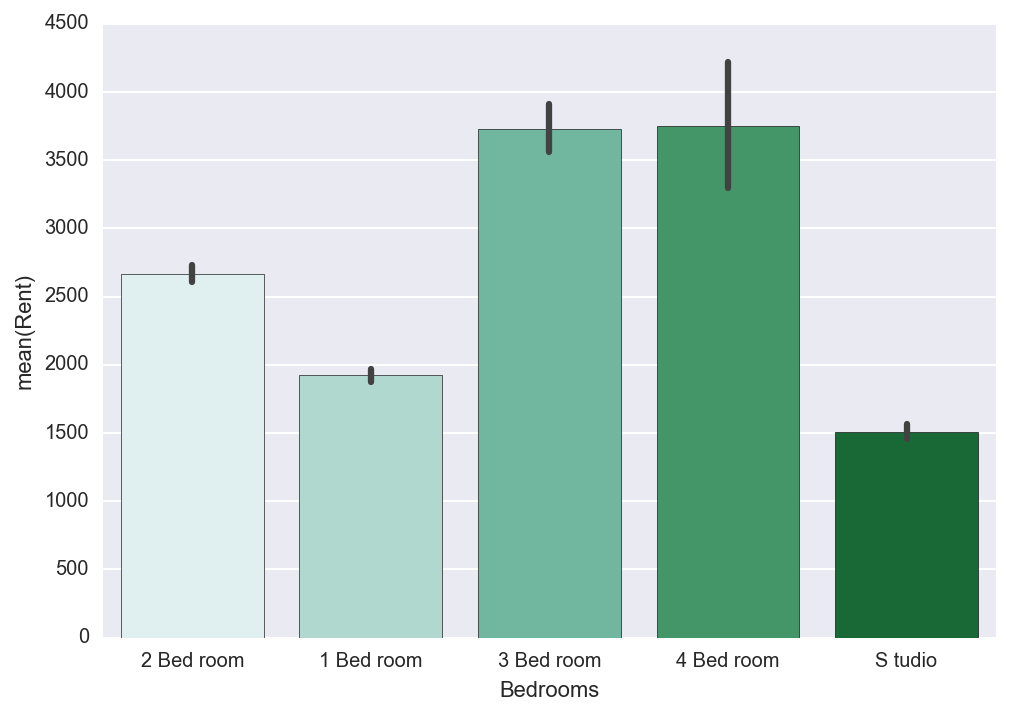

In [20]:
# First, convert RentCrawl 'Rent' to numeric
RentCrawl = RentCrawl[pd.to_numeric(RentCrawl.Rent, errors='coerce').notnull()]

# Then create the barplot
sns.barplot(RentCrawl['Bedrooms'], RentCrawl['Rent'],data=RentCrawl, palette='BuGn')

[None, None, None, None, None, None, None, None, None, None, None, None, None]

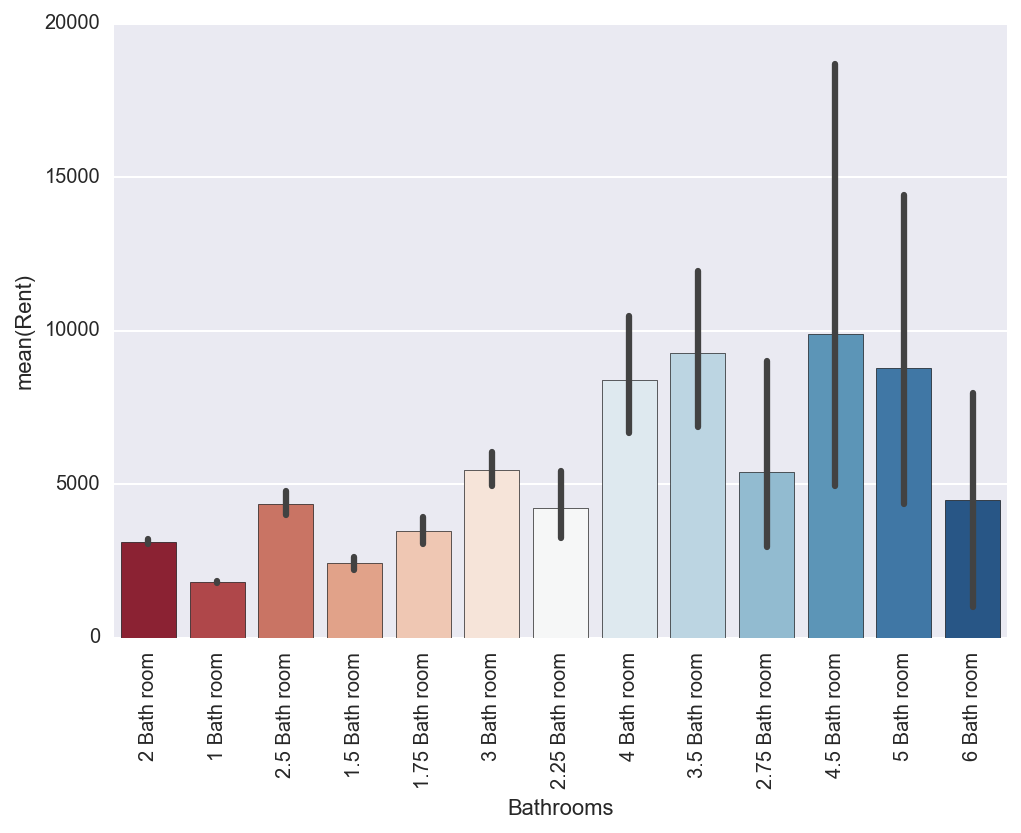

In [21]:
g = sns.barplot(RentCrawl['Bathrooms'], RentCrawl['Rent'],data=RentCrawl, palette='RdBu')

locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

In [22]:
RentCrawl['Rent'] = RentCrawl['Rent'].astype(int)

In [23]:
meanrent = pd.DataFrame(RentCrawl['Rent'].groupby(RentCrawl['ZIP']).mean())
meanrent = meanrent.sort_values(by=['Rent'], ascending=[False])
#meanrent
topten = meanrent[:10]
topten

,Rent
ZIP,
90265,13566.666667
90210,7297.000000
90272,7052.000000
90067,5788.500000
90077,5687.142857
90505,5567.785714
90402,5155.370370
90266,5075.357143
91210,5072.916667


[None, None, None, None, None, None, None, None, None, None]

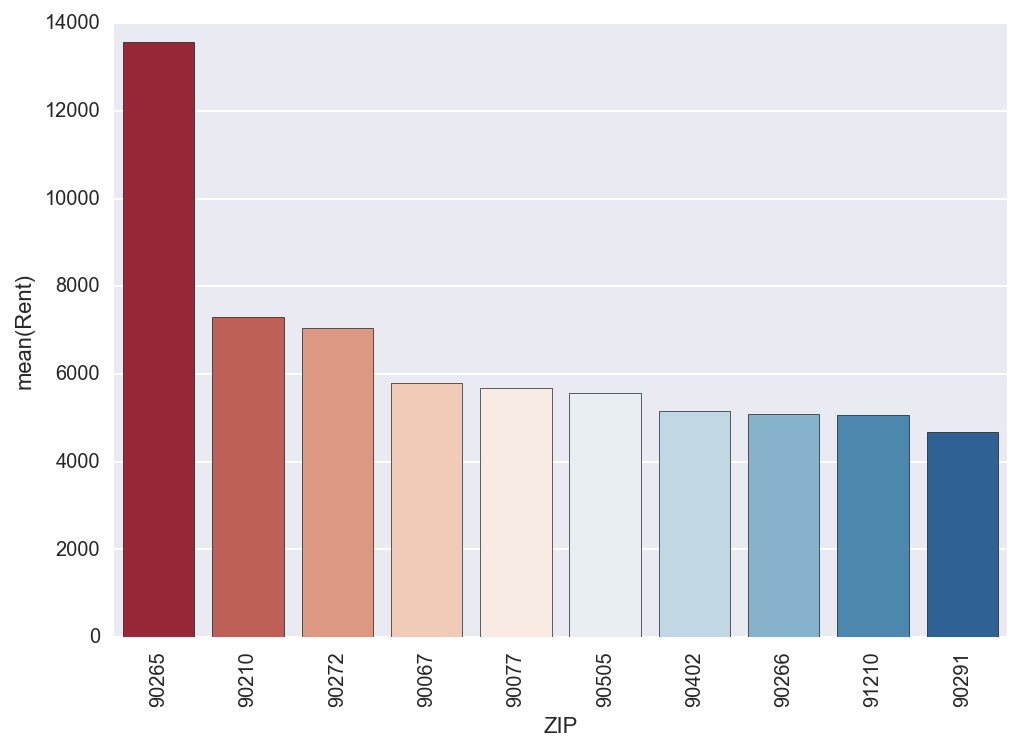

In [24]:
g = sns.barplot(topten.index, topten['Rent'],data=topten, palette='RdBu',order = topten.index)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

In [25]:
RentCrawl.head(5)

,Name,Address,ZIP,City,Description,Amenities,Bedrooms,Bathrooms,SqFt,Rent,Bedrooms2,Bathrooms2,SqFt2,Rent2
0,Rental Apartment 245 N. Alvarado St. (2 2) Los...,CA 90026 Los Angeles,90026,NaN,2 BEDROOM + 2 BATHROOM Modern / Controlled Acc...,"[easy access, modern, controlled access]",2 Bed room,2 Bath room,"1,000 sq . ft",1700,NaN,NaN,NaN,NaN
1,Rental Apartment 301 N. Alvarado St. (2 2) Los...,"301 N Alvarado St, Los Angeles, CA 90026",90026,los angeles,2 BEDROOM + 2 BATHROOM Modern / Controlled Acc...,"[easy access, modern, controlled access]",2 Bed room,2 Bath room,"1,000 sq . ft",1750,NaN,NaN,NaN,NaN
2,Ellendale Apartments,"2656 Ellendale Pl, Los Angeles, CA 90007",90007,los angeles,$1500 OFF MOVE-INEllendale is conveniently loc...,[conveniently located],2 Bed room,2 Bath room,"1,000 sq . ft",2895,NaN,NaN,NaN,NaN
3,"Rental Apartment 470 S. Mariposa Ave. #9, Los ...","470 S Mariposa Ave, Los Angeles, CA 90020",90020,los angeles,2 BEDROOM + 1.75 BATH Hardwood Floors Carpet F...,"[hardwood floors, sunlight, reserved parking]",2 Bed room,2 Bath room,"1,000 sq . ft",1475,NaN,NaN,NaN,NaN
4,Rental Apartment 820 S. Kingsley Dr. #101 Los ...,"820 S Kingsley Dr, Los Angeles, CA 90005",90005,los angeles,2 BEDROOM + 2 BATHROOM Prime K-Town / Mid-Wils...,[garage],2 Bed room,2 Bath room,"1,000 sq . ft",1550,NaN,NaN,NaN,NaN


## At this point, we should try to split out the amenities into one-hot encoded columns and make the bedroom and bathroom columns numeric

In [26]:
RentCrawl = RentCrawl[~RentCrawl.Bedrooms.isnull()] # Remove entries without values for number of bedrooms

In [27]:
# Transform the bedroom variable to be stricly numeric

sqft = re.compile(r".*[0-9]*[,]*\d+")

bedrooms =[]

for beds in RentCrawl.Bedrooms: 
    try:
        beds = beds.encode("UTF8")
        bedroom = re.findall(sqft, beds)
        if len(bedroom) > 0:
            #print(bedroom[0])
            #print(beds)
            bedrooms.append(bedroom[0])
        else:
            #pass
            bedrooms.append(1) # There are 1135 studio apartments. We should code these as 1 bedrooms
    except:
        print('exception:',beds)

#bedrooms

In [28]:
len(RentCrawl.Bedrooms)-len(bedrooms) # There are 1135 studio apartments. We should code these as 1 bedrooms
'''
count = 0
for entry in RentCrawl.Bedrooms:
    if entry[0] == 'S':
        print(entry)
        count += 1
print(count)
'''

0

"\ncount = 0\nfor entry in RentCrawl.Bedrooms:\n    if entry[0] == 'S':\n        print(entry)\n        count += 1\nprint(count)\n"

In [29]:
RentCrawl.Bedrooms = bedrooms

In [30]:
RentCrawl

,Name,Address,ZIP,City,Description,Amenities,Bedrooms,Bathrooms,SqFt,Rent,Bedrooms2,Bathrooms2,SqFt2,Rent2
0,Rental Apartment 245 N. Alvarado St. (2 2) Los...,CA 90026 Los Angeles,90026,NaN,2 BEDROOM + 2 BATHROOM Modern / Controlled Acc...,"[easy access, modern, controlled access]",2,2 Bath room,"1,000 sq . ft",1700,NaN,NaN,NaN,NaN
1,Rental Apartment 301 N. Alvarado St. (2 2) Los...,"301 N Alvarado St, Los Angeles, CA 90026",90026,los angeles,2 BEDROOM + 2 BATHROOM Modern / Controlled Acc...,"[easy access, modern, controlled access]",2,2 Bath room,"1,000 sq . ft",1750,NaN,NaN,NaN,NaN
2,Ellendale Apartments,"2656 Ellendale Pl, Los Angeles, CA 90007",90007,los angeles,$1500 OFF MOVE-INEllendale is conveniently loc...,[conveniently located],2,2 Bath room,"1,000 sq . ft",2895,NaN,NaN,NaN,NaN
3,"Rental Apartment 470 S. Mariposa Ave. #9, Los ...","470 S Mariposa Ave, Los Angeles, CA 90020",90020,los angeles,2 BEDROOM + 1.75 BATH Hardwood Floors Carpet F...,"[hardwood floors, sunlight, reserved parking]",2,2 Bath room,"1,000 sq . ft",1475,NaN,NaN,NaN,NaN
4,Rental Apartment 820 S. Kingsley Dr. #101 Los ...,"820 S Kingsley Dr, Los Angeles, CA 90005",90005,los angeles,2 BEDROOM + 2 BATHROOM Prime K-Town / Mid-Wils...,[garage],2,2 Bath room,"1,000 sq . ft",1550,NaN,NaN,NaN,NaN
5,"Great Central Location 2 bedroom, 1 bath","Walton Ave, Los Angeles, CA 90007",90007,los angeles,"Private Owner, Rafael Parada, Hablamos Espanol...",[private owner],2,1 Bath room,"1,000 sq . ft",1469,NaN,NaN,NaN,NaN
6,Outstanding Opportunity To Live At The Los Ang...,"W 43rd St, Los Angeles, CA 90037",90037,los angeles,Remodeled house for a large family2 bedroom 1 ...,"[pets allowed, gated]",2,1 Bath room,"1,000 sq . ft",2100,NaN,NaN,NaN,NaN
7,2 bedrooms Apartment - Property Management Com...,"E 52nd St, Maywood, CA 90270",90270,maywood,"Del Sol Properties, Lorena Lomeli, Hablamos Es...",[],2,1 Bath room,"1,000 sq . ft",1200,NaN,NaN,NaN,NaN
8,"Amazing 2 bedroom, 2 bath for rent. Gated park...","S St Andrews Pl, Los Angeles, CA",missing,los angeles,Wilshire. Andrews Towers is a beautifully main...,"[newly renovated, beautifully maintained, beau...",2,2 Bath room,"1,000 sq . ft",2375,NaN,NaN,NaN,NaN
9,2 bd/1 ba,"3935 Guardia Ave, Los Angeles, CA 90032",90032,los angeles,NaN,,2,1 Bath room,"1,000 sq . ft",2000,NaN,NaN,NaN,NaN


In [31]:
# Transform the bathroom variable to be stricly numeric

sqft = re.compile(r".*[0-9]")

bathrooms =[]

for baths in RentCrawl.Bathrooms: 
    try:
        baths = baths.encode("UTF8")
        bathroom = re.findall(sqft, baths)
        if len(bathroom) > 0:
            bathrooms.append(bathroom[0][0])
        else:
            bathrooms.append(bathroom[0])
    except:
        bathrooms.append(1)

#bathrooms
len(bathrooms)
len(RentCrawl)

8983

8983

In [32]:
RentCrawl.Bathrooms = bathrooms

In [33]:
RentCrawl.head(10)

,Name,Address,ZIP,City,Description,Amenities,Bedrooms,Bathrooms,SqFt,Rent,Bedrooms2,Bathrooms2,SqFt2,Rent2
0,Rental Apartment 245 N. Alvarado St. (2 2) Los...,CA 90026 Los Angeles,90026,NaN,2 BEDROOM + 2 BATHROOM Modern / Controlled Acc...,"[easy access, modern, controlled access]",2,2,"1,000 sq . ft",1700,NaN,NaN,NaN,NaN
1,Rental Apartment 301 N. Alvarado St. (2 2) Los...,"301 N Alvarado St, Los Angeles, CA 90026",90026,los angeles,2 BEDROOM + 2 BATHROOM Modern / Controlled Acc...,"[easy access, modern, controlled access]",2,2,"1,000 sq . ft",1750,NaN,NaN,NaN,NaN
2,Ellendale Apartments,"2656 Ellendale Pl, Los Angeles, CA 90007",90007,los angeles,$1500 OFF MOVE-INEllendale is conveniently loc...,[conveniently located],2,2,"1,000 sq . ft",2895,NaN,NaN,NaN,NaN
3,"Rental Apartment 470 S. Mariposa Ave. #9, Los ...","470 S Mariposa Ave, Los Angeles, CA 90020",90020,los angeles,2 BEDROOM + 1.75 BATH Hardwood Floors Carpet F...,"[hardwood floors, sunlight, reserved parking]",2,2,"1,000 sq . ft",1475,NaN,NaN,NaN,NaN
4,Rental Apartment 820 S. Kingsley Dr. #101 Los ...,"820 S Kingsley Dr, Los Angeles, CA 90005",90005,los angeles,2 BEDROOM + 2 BATHROOM Prime K-Town / Mid-Wils...,[garage],2,2,"1,000 sq . ft",1550,NaN,NaN,NaN,NaN
5,"Great Central Location 2 bedroom, 1 bath","Walton Ave, Los Angeles, CA 90007",90007,los angeles,"Private Owner, Rafael Parada, Hablamos Espanol...",[private owner],2,1,"1,000 sq . ft",1469,NaN,NaN,NaN,NaN
6,Outstanding Opportunity To Live At The Los Ang...,"W 43rd St, Los Angeles, CA 90037",90037,los angeles,Remodeled house for a large family2 bedroom 1 ...,"[pets allowed, gated]",2,1,"1,000 sq . ft",2100,NaN,NaN,NaN,NaN
7,2 bedrooms Apartment - Property Management Com...,"E 52nd St, Maywood, CA 90270",90270,maywood,"Del Sol Properties, Lorena Lomeli, Hablamos Es...",[],2,1,"1,000 sq . ft",1200,NaN,NaN,NaN,NaN
8,"Amazing 2 bedroom, 2 bath for rent. Gated park...","S St Andrews Pl, Los Angeles, CA",missing,los angeles,Wilshire. Andrews Towers is a beautifully main...,"[newly renovated, beautifully maintained, beau...",2,2,"1,000 sq . ft",2375,NaN,NaN,NaN,NaN
9,2 bd/1 ba,"3935 Guardia Ave, Los Angeles, CA 90032",90032,los angeles,NaN,,2,1,"1,000 sq . ft",2000,NaN,NaN,NaN,NaN


## Transform square footage to be strictly numeric

In [44]:
sqft = re.compile(r"[0-9]*[,]*[0-9]+")

Squarefootage = []

for item in RentCrawl['SqFt']:
    try:
        feet = re.findall(sqft, item.encode("UTF8"))
        feet = feet[0].replace(',', '')
        Squarefootage.append(int(feet))

    except:
        #pass
        Squarefootage.append(item)
  
#Squarefootage

In [35]:
RentCrawl['Squarefootage'] = Squarefootage

In [36]:
RentCrawl = RentCrawl.iloc[:,[0,1,2,3,4,5,6,7,8,14,9,10,11,12,13]]
RentCrawl

,Name,Address,ZIP,City,Description,Amenities,Bedrooms,Bathrooms,SqFt,Squarefootage,Rent,Bedrooms2,Bathrooms2,SqFt2,Rent2
0,Rental Apartment 245 N. Alvarado St. (2 2) Los...,CA 90026 Los Angeles,90026,NaN,2 BEDROOM + 2 BATHROOM Modern / Controlled Acc...,"[easy access, modern, controlled access]",2,2,"1,000 sq . ft",1000.0,1700,NaN,NaN,NaN,NaN
1,Rental Apartment 301 N. Alvarado St. (2 2) Los...,"301 N Alvarado St, Los Angeles, CA 90026",90026,los angeles,2 BEDROOM + 2 BATHROOM Modern / Controlled Acc...,"[easy access, modern, controlled access]",2,2,"1,000 sq . ft",1000.0,1750,NaN,NaN,NaN,NaN
2,Ellendale Apartments,"2656 Ellendale Pl, Los Angeles, CA 90007",90007,los angeles,$1500 OFF MOVE-INEllendale is conveniently loc...,[conveniently located],2,2,"1,000 sq . ft",1000.0,2895,NaN,NaN,NaN,NaN
3,"Rental Apartment 470 S. Mariposa Ave. #9, Los ...","470 S Mariposa Ave, Los Angeles, CA 90020",90020,los angeles,2 BEDROOM + 1.75 BATH Hardwood Floors Carpet F...,"[hardwood floors, sunlight, reserved parking]",2,2,"1,000 sq . ft",1000.0,1475,NaN,NaN,NaN,NaN
4,Rental Apartment 820 S. Kingsley Dr. #101 Los ...,"820 S Kingsley Dr, Los Angeles, CA 90005",90005,los angeles,2 BEDROOM + 2 BATHROOM Prime K-Town / Mid-Wils...,[garage],2,2,"1,000 sq . ft",1000.0,1550,NaN,NaN,NaN,NaN
5,"Great Central Location 2 bedroom, 1 bath","Walton Ave, Los Angeles, CA 90007",90007,los angeles,"Private Owner, Rafael Parada, Hablamos Espanol...",[private owner],2,1,"1,000 sq . ft",1000.0,1469,NaN,NaN,NaN,NaN
6,Outstanding Opportunity To Live At The Los Ang...,"W 43rd St, Los Angeles, CA 90037",90037,los angeles,Remodeled house for a large family2 bedroom 1 ...,"[pets allowed, gated]",2,1,"1,000 sq . ft",1000.0,2100,NaN,NaN,NaN,NaN
7,2 bedrooms Apartment - Property Management Com...,"E 52nd St, Maywood, CA 90270",90270,maywood,"Del Sol Properties, Lorena Lomeli, Hablamos Es...",[],2,1,"1,000 sq . ft",1000.0,1200,NaN,NaN,NaN,NaN
8,"Amazing 2 bedroom, 2 bath for rent. Gated park...","S St Andrews Pl, Los Angeles, CA",missing,los angeles,Wilshire. Andrews Towers is a beautifully main...,"[newly renovated, beautifully maintained, beau...",2,2,"1,000 sq . ft",1000.0,2375,NaN,NaN,NaN,NaN
9,2 bd/1 ba,"3935 Guardia Ave, Los Angeles, CA 90032",90032,los angeles,NaN,,2,1,"1,000 sq . ft",1000.0,2000,NaN,NaN,NaN,NaN


In [37]:
# Remove rows that are missing values in Squarefootage
RentCrawl = RentCrawl[~RentCrawl['Squarefootage'].isnull()]
RentCrawl.head(5)

,Name,Address,ZIP,City,Description,Amenities,Bedrooms,Bathrooms,SqFt,Squarefootage,Rent,Bedrooms2,Bathrooms2,SqFt2,Rent2
0,Rental Apartment 245 N. Alvarado St. (2 2) Los...,CA 90026 Los Angeles,90026,NaN,2 BEDROOM + 2 BATHROOM Modern / Controlled Acc...,"[easy access, modern, controlled access]",2,2,"1,000 sq . ft",1000.0,1700,NaN,NaN,NaN,NaN
1,Rental Apartment 301 N. Alvarado St. (2 2) Los...,"301 N Alvarado St, Los Angeles, CA 90026",90026,los angeles,2 BEDROOM + 2 BATHROOM Modern / Controlled Acc...,"[easy access, modern, controlled access]",2,2,"1,000 sq . ft",1000.0,1750,NaN,NaN,NaN,NaN
2,Ellendale Apartments,"2656 Ellendale Pl, Los Angeles, CA 90007",90007,los angeles,$1500 OFF MOVE-INEllendale is conveniently loc...,[conveniently located],2,2,"1,000 sq . ft",1000.0,2895,NaN,NaN,NaN,NaN
3,"Rental Apartment 470 S. Mariposa Ave. #9, Los ...","470 S Mariposa Ave, Los Angeles, CA 90020",90020,los angeles,2 BEDROOM + 1.75 BATH Hardwood Floors Carpet F...,"[hardwood floors, sunlight, reserved parking]",2,2,"1,000 sq . ft",1000.0,1475,NaN,NaN,NaN,NaN
4,Rental Apartment 820 S. Kingsley Dr. #101 Los ...,"820 S Kingsley Dr, Los Angeles, CA 90005",90005,los angeles,2 BEDROOM + 2 BATHROOM Prime K-Town / Mid-Wils...,[garage],2,2,"1,000 sq . ft",1000.0,1550,NaN,NaN,NaN,NaN


In [38]:
len(RentCrawl)

2977

[(0, 10000)]

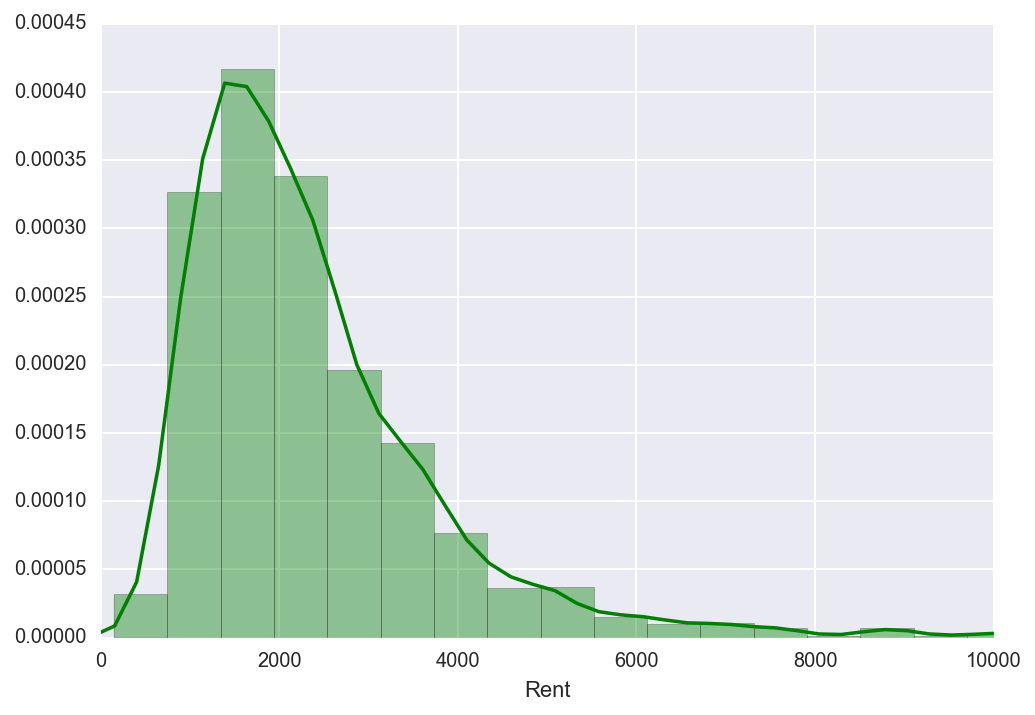

In [50]:
g = sns.distplot(RentCrawl.Rent,color='green')

g.set(xlim=(0, 10000))

[(0, 4000)]

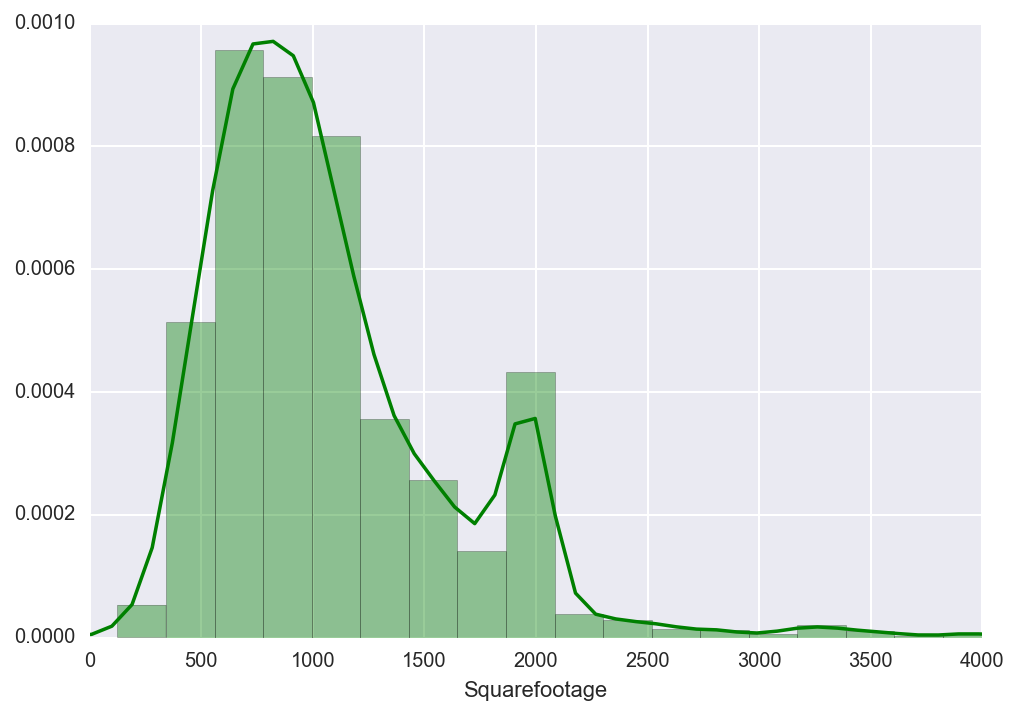

In [48]:
g = sns.distplot(RentCrawl.Squarefootage,color='green')

g.set(xlim=(0, 4000))

[(0, 4000)]

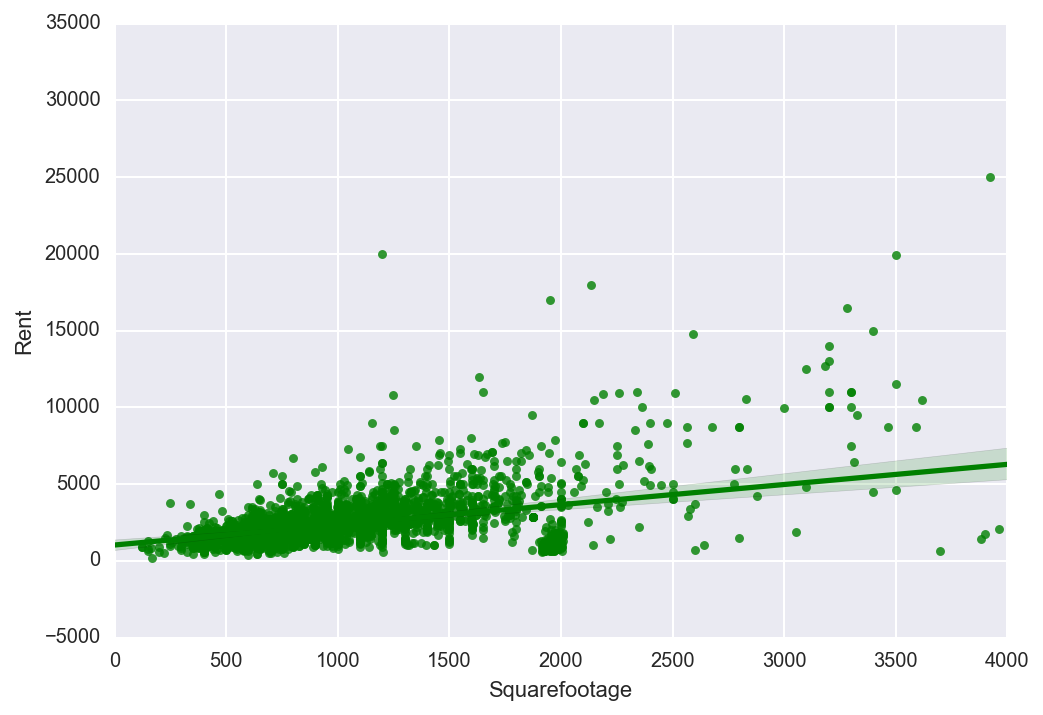

In [53]:
g = sns.regplot(RentCrawl.Squarefootage,RentCrawl.Rent,color='green')

g.set(xlim=(0, 4000))

## Capture square footage from description if missing from the actual square footage column
## Hold off on this until we have more data from Markeza

In [99]:
#len(RentCrawl[RentCrawl['SqFt'].isnull()]) # There are 6007 null entries for SqFt

'''
sqft = re.compile(r"\s[0-9]*[,]*[0-9]+\s[sS][qQ]uare\s[fF]+[a-zA-Z]*|\s[0-9]*[,]*[0-9]+\s[sS][qQ][.]*\s[fF]+[a-zA-Z]*")

feetcount = 0

for item in RentCrawl[RentCrawl['SqFt'].isnull()]['Description']:
    #print(item)
    try:
        feet = re.findall(sqft, item.encode("UTF8"))
        if len(feet) > 0:
            print(feet)
            feetcount += 1
        else:
            pass
            #print(feet)
    except:
        pass

feetcount

'''

'\nsqft = re.compile(r"\\s[0-9]*[,]*[0-9]+\\s[sS][qQ]uare\\s[fF]+[a-zA-Z]*|\\s[0-9]*[,]*[0-9]+\\s[sS][qQ][.]*\\s[fF]+[a-zA-Z]*")\n\nfeetcount = 0\n\nfor item in RentCrawl[RentCrawl[\'SqFt\'].isnull()][\'Description\']:\n    #print(item)\n    try:\n        feet = re.findall(sqft, item.encode("UTF8"))\n        if len(feet) > 0:\n            print(feet)\n            feetcount += 1\n        else:\n            pass\n            #print(feet)\n    except:\n        pass\n\nfeetcount\n\n'

In [100]:
RentCrawl.columns

Index([u'Name', u'Address', u'ZIP', u'City', u'Description', u'Amenities',
       u'Bedrooms', u'Bathrooms', u'SqFt', u'Squarefootage', u'Rent',
       u'Bedrooms2', u'Bathrooms2', u'SqFt2', u'Rent2'],
      dtype='object')

In [142]:
# Split RentCrawl into X and Y dataframes
X = RentCrawl.loc[:,['ZIP','Amenities','Bedrooms','Bathrooms','Squarefootage']]
Y = RentCrawl.loc[:,'Rent']

In [143]:
X

,ZIP,Amenities,Bedrooms,Bathrooms,Squarefootage
0,90026,"[easy access, modern, controlled access]",2,2,1000.0
1,90026,"[easy access, modern, controlled access]",2,2,1000.0
2,90007,[conveniently located],2,2,1000.0
3,90020,"[hardwood floors, sunlight, reserved parking]",2,2,1000.0
4,90005,[garage],2,2,1000.0
5,90007,[private owner],2,1,1000.0
6,90037,"[pets allowed, gated]",2,1,1000.0
7,90270,[],2,1,1000.0
8,missing,"[newly renovated, beautifully maintained, beau...",2,2,1000.0
9,90032,,2,1,1000.0


In [105]:
Y

0       1700
1       1750
2       2895
3       1475
4       1550
5       1469
6       2100
7       1200
8       2375
9       2000
10      2089
11      1750
13      2495
14      2400
15      1250
16      3300
17      2400
18      1795
19      2250
20      3600
21      2695
22      3600
23      1650
24      1200
25      3650
26      3000
27      1500
28      3850
29      3500
30      1639
31      2800
32      1900
33      1995
34      2200
35      2195
36      2695
37      3195
38      1875
39      2475
40      1575
41      2375
42      2500
43      2163
44      2695
45      3395
46      1850
47      1350
48      2650
49      2575
50      2425
51      2425
52      2695
53      1200
54      1348
55      3650
56      2295
58      1895
59      1695
60      2250
61      2250
62      4500
63      1400
64      1495
65      2195
66      1500
67      3750
68      2195
69      1625
70      1849
71      2595
72      1895
73      1400
74      1550
75      1750
76      2545
        ... 
2977    1135

In [144]:
X = X.iloc[:,[0,2,3,4]]

In [145]:
X

,ZIP,Bedrooms,Bathrooms,Squarefootage
0,90026,2,2,1000.0
1,90026,2,2,1000.0
2,90007,2,2,1000.0
3,90020,2,2,1000.0
4,90005,2,2,1000.0
5,90007,2,1,1000.0
6,90037,2,1,1000.0
7,90270,2,1,1000.0
8,missing,2,2,1000.0
9,90032,2,1,1000.0


In [157]:
# Make a really simple model without the amenities

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:,1:], Y, test_size=0.33, random_state=42)

# Use dummy variables for categoricals so we can standardize the data
#one_hot_encoded_training_predictors = pd.get_dummies(X_train)
#one_hot_encoded_test_predictors = pd.get_dummies(X_test)

# Ensure that the column names and column order are equivalent in both sets
#final_train, final_test = one_hot_encoded_training_predictors.align(one_hot_encoded_test_predictors,
#                                                                    join='left', 
#                                                                    axis=1)

In [158]:
X_train

,Bedrooms,Bathrooms,Squarefootage
297,2,1,1100.0
1596,1,1,450.0
1803,1,1,551.0
2751,1,1,890.0
425,2,1,1175.0
481,4,2,1200.0
619,2,2,1290.0
2815,2,1,900.0
1839,1,1,578.0
940,2,2,1632.0


In [166]:
param_grid = {"n_estimators": [100,200],
    "min_samples_split": [2,3]}

model = RandomForestRegressor(random_state=0,min_samples_leaf=10)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid.fit(X_train, y_train)

print(grid.best_score_)
print(grid.best_params_)


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=10,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [100, 200], 'min_samples_split': [2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

0.532863058063
{'min_samples_split': 2, 'n_estimators': 100}


In [168]:
regressor = RandomForestRegressor(random_state=0, n_estimators=100, max_depth=None, 
                                  min_samples_leaf=10, min_samples_split=2, bootstrap=False)

regressor.fit(final_train, y_train)

regressor.score(final_train, y_train)
regressor.score(final_test, y_test)

y_pred = regressor.predict(final_test)

# Plot the predictions vs. actual prices
plt.figure(figsize=(8, 6))
plt.scatter(x=y_test, y=y_pred)
plt.xlim([0,10000])
plt.ylim([0,10000])
plt.plot([0,10000],[0,10000])
plt.show()

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=10,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

0.21606956282825054

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

## At this point, expand the amenities column into one-hot encoded vectors to start building a model 

In [108]:
checklist

['hardwood floors',
 'pets allowed',
 'pets welcome',
 'pet friendly',
 'penthouse',
 'city views',
 'move in special',
 'laundry',
 'washer dryer',
 'laminate',
 'pool',
 'gym',
 'luxurious',
 'garage',
 'utilities included',
 'remodeled kitchen',
 'private yard',
 'easy access',
 'duplex',
 'walk up',
 'open floor plan',
 'private owner',
 'tile floors',
 'remodeled bathroom',
 'modern kitchen',
 'modern',
 'stainless steel appliances',
 'new appliances',
 'natural sunlight',
 'sunlight',
 'new construction',
 'newly renovated',
 'freshly painted',
 'newly painted',
 'new paint',
 'a/c',
 'prime location',
 'controlled access',
 'gated',
 'free rent',
 'balcony',
 'spacious balcony',
 'covered parking',
 'indoor parking',
 'free parking',
 'prime location',
 'reserved parking',
 'wheelchair accessible',
 'cozy',
 'section 8',
 'quiet',
 'waterfront views',
 'public transit',
 'fully furnishedprivate',
 'brand new',
 'upgraded',
 'walk score',
 'low income',
 'affordable',
 'convenien

In [114]:
for i in X.Amenities[0]:
    print(i)

easy access
modern
controlled access


In [132]:
for entry in X.Amenities:
    if len(entry) > 0:
        print([i for i in entry])
    else:
        pass
        #print(entry)
    print('------------------------------------')

['easy access', 'modern', 'controlled access']
------------------------------------
['easy access', 'modern', 'controlled access']
------------------------------------
['conveniently located']
------------------------------------
['hardwood floors', 'sunlight', 'reserved parking']
------------------------------------
['garage']
------------------------------------
['private owner']
------------------------------------
['pets allowed', 'gated']
------------------------------------
------------------------------------
['newly renovated', 'beautifully maintained', 'beautiful']
------------------------------------
[' ']
------------------------------------
['hardwood floors', 'open floor plan', 'tile floors', 'freshly painted', 'a/c', 'open floor plan']
------------------------------------
------------------------------------
['prime location', 'prime location']
------------------------------------
------------------------------------
['private owner']
------------------------------------


In [134]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
# define example
data = ['cold', 'cold', 'warm', 'cold', 'hot', 'hot', 'warm', 'cold', 'warm', 'hot']
values = array(data)
print(values)
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)

['cold' 'cold' 'warm' 'cold' 'hot' 'hot' 'warm' 'cold' 'warm' 'hot']
[0 0 2 0 1 1 2 0 2 1]
[[ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]]


In [537]:
# Expand the amenities variable to do dummy coding with each entry in the 'checklist' list
'''

pools = []

for i in RentCrawl.amenities:
    if len(i) > 0:
        if 'pool' in i:
            pools.append('Yes')
        else:
            pools.append('No')
    else:
        pools.append('No')
        
len(pools)    

RentCrawl['has_pool'] = pools

'''

In [60]:
RentCrawl.head(10)

,Name,Address,ZIP,City,Description,Amenities,Bedrooms,Bathrooms,SqFt,Rent,Bedrooms2,Bathrooms2,SqFt2,Rent2
0,Rental Apartment 245 N. Alvarado St. (2 2) Los...,CA 90026 Los Angeles,90026,NaN,2 BEDROOM + 2 BATHROOM Modern / Controlled Acc...,"[easy access, modern, controlled access]",2,2,"1,000 sq . ft",1700,NaN,NaN,NaN,NaN
1,Rental Apartment 301 N. Alvarado St. (2 2) Los...,"301 N Alvarado St, Los Angeles, CA 90026",90026,los angeles,2 BEDROOM + 2 BATHROOM Modern / Controlled Acc...,"[easy access, modern, controlled access]",2,2,"1,000 sq . ft",1750,NaN,NaN,NaN,NaN
2,Ellendale Apartments,"2656 Ellendale Pl, Los Angeles, CA 90007",90007,los angeles,$1500 OFF MOVE-INEllendale is conveniently loc...,[conveniently located],2,2,"1,000 sq . ft",2895,NaN,NaN,NaN,NaN
3,"Rental Apartment 470 S. Mariposa Ave. #9, Los ...","470 S Mariposa Ave, Los Angeles, CA 90020",90020,los angeles,2 BEDROOM + 1.75 BATH Hardwood Floors Carpet F...,"[hardwood floors, sunlight, reserved parking]",2,2,"1,000 sq . ft",1475,NaN,NaN,NaN,NaN
4,Rental Apartment 820 S. Kingsley Dr. #101 Los ...,"820 S Kingsley Dr, Los Angeles, CA 90005",90005,los angeles,2 BEDROOM + 2 BATHROOM Prime K-Town / Mid-Wils...,[garage],2,2,"1,000 sq . ft",1550,NaN,NaN,NaN,NaN
5,"Great Central Location 2 bedroom, 1 bath","Walton Ave, Los Angeles, CA 90007",90007,los angeles,"Private Owner, Rafael Parada, Hablamos Espanol...",[private owner],2,1,"1,000 sq . ft",1469,NaN,NaN,NaN,NaN
6,Outstanding Opportunity To Live At The Los Ang...,"W 43rd St, Los Angeles, CA 90037",90037,los angeles,Remodeled house for a large family2 bedroom 1 ...,"[pets allowed, gated]",2,1,"1,000 sq . ft",2100,NaN,NaN,NaN,NaN
7,2 bedrooms Apartment - Property Management Com...,"E 52nd St, Maywood, CA 90270",90270,maywood,"Del Sol Properties, Lorena Lomeli, Hablamos Es...",[],2,1,"1,000 sq . ft",1200,NaN,NaN,NaN,NaN
8,"Amazing 2 bedroom, 2 bath for rent. Gated park...","S St Andrews Pl, Los Angeles, CA",missing,los angeles,Wilshire. Andrews Towers is a beautifully main...,"[newly renovated, beautifully maintained, beau...",2,2,"1,000 sq . ft",2375,NaN,NaN,NaN,NaN
9,2 bd/1 ba,"3935 Guardia Ave, Los Angeles, CA 90032",90032,los angeles,NaN,,2,1,"1,000 sq . ft",2000,NaN,NaN,NaN,NaN


In [552]:
RentCrawl[RentCrawl['Rent'] != int]

,Name,Address,ZIP,City,Description,Amenities,Bedrooms,Bathrooms,SqFt,Rent,Bedrooms2,Bathrooms2,SqFt2,Rent2
0,Rental Apartment 245 N. Alvarado St. (2 2) Los...,CA 90026 Los Angeles,90026,NaN,2 BEDROOM + 2 BATHROOM Modern / Controlled Acc...,"[easy access, controlled access]",2 Bed room,2 Bath room,"1,000 sq . ft",1700,NaN,NaN,NaN,NaN
1,Rental Apartment 301 N. Alvarado St. (2 2) Los...,"301 N Alvarado St, Los Angeles, CA 90026",90026,los angeles,2 BEDROOM + 2 BATHROOM Modern / Controlled Acc...,"[easy access, controlled access]",2 Bed room,2 Bath room,"1,000 sq . ft",1750,NaN,NaN,NaN,NaN
2,Ellendale Apartments,"2656 Ellendale Pl, Los Angeles, CA 90007",90007,los angeles,$1500 OFF MOVE-INEllendale is conveniently loc...,[conveniently located],2 Bed room,2 Bath room,"1,000 sq . ft",2895,NaN,NaN,NaN,NaN
3,"Rental Apartment 470 S. Mariposa Ave. #9, Los ...","470 S Mariposa Ave, Los Angeles, CA 90020",90020,los angeles,2 BEDROOM + 1.75 BATH Hardwood Floors Carpet F...,"[hardwood floors, sunlight, reserved parking]",2 Bed room,2 Bath room,"1,000 sq . ft",1475,NaN,NaN,NaN,NaN
4,Rental Apartment 820 S. Kingsley Dr. #101 Los ...,"820 S Kingsley Dr, Los Angeles, CA 90005",90005,los angeles,2 BEDROOM + 2 BATHROOM Prime K-Town / Mid-Wils...,[garage],2 Bed room,2 Bath room,"1,000 sq . ft",1550,NaN,NaN,NaN,NaN
5,"Great Central Location 2 bedroom, 1 bath","Walton Ave, Los Angeles, CA 90007",90007,los angeles,"Private Owner, Rafael Parada, Hablamos Espanol...",[private owner],2 Bed room,1 Bath room,"1,000 sq . ft",1469,NaN,NaN,NaN,NaN
6,Outstanding Opportunity To Live At The Los Ang...,"W 43rd St, Los Angeles, CA 90037",90037,los angeles,Remodeled house for a large family2 bedroom 1 ...,"[pets allowed, gated]",2 Bed room,1 Bath room,"1,000 sq . ft",2100,NaN,NaN,NaN,NaN
7,2 bedrooms Apartment - Property Management Com...,"E 52nd St, Maywood, CA 90270",90270,maywood,"Del Sol Properties, Lorena Lomeli, Hablamos Es...",[],2 Bed room,1 Bath room,"1,000 sq . ft",1200,NaN,NaN,NaN,NaN
8,"Amazing 2 bedroom, 2 bath for rent. Gated park...","S St Andrews Pl, Los Angeles, CA",missing,los angeles,Wilshire. Andrews Towers is a beautifully main...,[newly renovated],2 Bed room,2 Bath room,"1,000 sq . ft",2375,NaN,NaN,NaN,NaN
9,2 bd/1 ba,"3935 Guardia Ave, Los Angeles, CA 90032",90032,los angeles,NaN,,2 Bed room,1 Bath room,"1,000 sq . ft",2000,NaN,NaN,NaN,NaN


In [429]:
RentCrawl.Name

0       Rental Apartment 245 N. Alvarado St. (2 2) Los...
1       Rental Apartment 301 N. Alvarado St. (2 2) Los...
2                                    Ellendale Apartments
3       Rental Apartment 470 S. Mariposa Ave. #9, Los ...
4       Rental Apartment 820 S. Kingsley Dr. #101 Los ...
5                Great Central Location 2 bedroom, 1 bath
6       Outstanding Opportunity To Live At The Los Ang...
7       2 bedrooms Apartment - Property Management Com...
8       Amazing 2 bedroom, 2 bath for rent. Gated park...
9                                               2 bd/1 ba
10                                   5906 Willoughby Ave.
11                                   821 Bridewell Street
12                                   2626 S. Orange Drive
13                             350-352 North Stanley Ave.
14      Rental Apartment 1326 N. Alta Vista Blvd. ($2,...
15      Apartment in quiet area, spacious with big kit...
16                   1616 N La Brea Ave Apt 209 Hollywood
17            

In [434]:
import re

#regex= re.compile(r"(?:\b[9]\d{4})")
#regex= re.compile(r"(.*\s([1-9]+)\s[a-z]+)")
#regex= re.compile(r'^(\D*)(.*)$')

#regex= re.compile(r"\d[,]\d+\s[a-zA-Z]*\s|\d+\s[a-zA-Z]*\s")
#findall = re.findall(regex, description)
#if len(findall) > 0:
#    print(findall)

    

'''
 

discount = re.compile(r"\d\s*\d*[,]*\d+[,]\d+\soff\s|\d\s*\d*[,]*\d+\soff\s")

for description in descriptions:
    disc = re.findall(discount, description)

    if len(disc) > 0:
        print(disc)#,description)


'''   
        
        

proximity = re.compile(r"\sblocks\sfrom\s[a-zA-Z]*\s[a-zA-Z]*[.]")
bedroom = re.compile(r"\s[0-9]\sbed[a-zA-Z]*\s|\s[0-9]\sbed[a-zA-Z]*\s")
bathroom = re.compile(r"\s[0-9]\d+\sbath[a-zA-Z]*\s|\s[0-9]\sbath[a-zA-Z]*\s|\s[0-9]\s[0-9]+\sbath[a-zA-Z]*\s")
deposit = re.compile(r"\s[0-9]*[,]\d+\sdeposit\s[0-9]*|\s[0-9]+\sdeposit\s[0-9]*")


for description in descriptions:   
    bed = re.findall(bedroom, description)
    #if len(bed) > 0:
    #    print(bed[0])
    
    
    #bath = re.findall(bathroom, description)
    #if len(bath) > 0:
    #    print(bath[0].split(' ')[1],bath[0].split(' ')[2],bath[0].split(' ')[3])
    
    
    #dep = re.findall(deposit, description)
    #if len(dep) > 0:
     #   print(dep,description)
     

    prox = re.findall(proximity,description)
    if len(prox) > 0:
        print(prox[0])
    

'\n \n\ndiscount = re.compile(r"\\d\\s*\\d*[,]*\\d+[,]\\d+\\soff\\s|\\d\\s*\\d*[,]*\\d+\\soff\\s")\n\nfor description in descriptions:\n    disc = re.findall(discount, description)\n\n    if len(disc) > 0:\n        print(disc)#,description)\n\n\n'

 blocks from ventura blvd.
 blocks from downtown burbank.
 blocks from the beach.
 blocks from lake merritt.
 blocks from the ocean.
 blocks from the beach.
 blocks from the beach.
 blocks from the beach.
 blocks from main st.
 blocks from the metro.
 blocks from the lake.
 blocks from lake merritt.
 blocks from the lake.
 blocks from lake merritt.
 blocks from the lake.
 blocks from littlejohn park.


In [284]:
RentCrawl.Decription

0       2 BEDROOM + 2 BATHROOM Modern / Controlled Acc...
1       2 BEDROOM + 2 BATHROOM Modern / Controlled Acc...
2       $1500 OFF MOVE-INEllendale is conveniently loc...
3       2 BEDROOM + 1.75 BATH Hardwood Floors Carpet F...
4       2 BEDROOM + 2 BATHROOM Prime K-Town / Mid-Wils...
5       Private Owner, Rafael Parada, Hablamos Espanol...
6       Remodeled house for a large family2 bedroom 1 ...
7       Del Sol Properties, Lorena Lomeli, Hablamos Es...
8       Wilshire. Andrews Towers is a beautifully main...
9                                                     NaN
10      Hardwood Floors in Large Open Floor Plan ? Top...
11                                                #ERROR!
12                                                    NaN
13      LARGE VINTAGE 1920s ALL HARDWOOD CLASSIC 2BR/1...
14      1 BEDROOM + Dining Room + 1 BATHROOM Stunning ...
15      Private Owner, Alex Parizher, Hablamos Espanol...
16      Welcome to The Lofts on La Brea. This BRAND NE...
17      Lovely

In [95]:
# Define these to call them later

tokenizer = RegexpTokenizer(r'\w+')

# create English stop words list
en_stop = get_stop_words('en')

# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()
    

In [96]:
texts = []
for i in descriptions:
    #print i
    try:
        tokens = tokenizer.tokenize(i)
        stopped_tokens = [i for i in tokens if not i in en_stop]
        #print(stopped_tokens)
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        #print(stemmed_tokens)
        texts.append(stemmed_tokens)
    except:
        pass

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


In [89]:
# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)

UnicodeDecodeError: 'utf8' codec can't decode byte 0xef in position 0: unexpected end of data

In [90]:
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]

UnicodeDecodeError: 'utf8' codec can't decode byte 0xef in position 0: unexpected end of data

In [91]:
# generate LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=20, id2word = dictionary, passes=20)
print(ldamodel.print_topics(num_topics=3, num_words=3))

[(0, u'0.083*"build" + 0.083*"wilshir" + 0.083*"maintain"'), (10, u'0.083*"build" + 0.083*"wilshir" + 0.083*"beauti"'), (5, u'0.084*"wilshir" + 0.084*"build" + 0.083*"offer"')]


In [92]:
print(ldamodel.print_topics(num_topics=10, num_words=4))

[(11, u'0.084*"wilshir" + 0.084*"build" + 0.083*"mid" + 0.083*"tower"'), (1, u'0.083*"wilshir" + 0.083*"build" + 0.083*"beauti" + 0.083*"mid"'), (7, u'0.083*"build" + 0.083*"wilshir" + 0.083*"mid" + 0.083*"locat"'), (18, u'0.083*"build" + 0.083*"wilshir" + 0.083*"maintain" + 0.083*"locat"'), (16, u'0.143*"build" + 0.143*"wilshir" + 0.071*"offer" + 0.071*"beauti"'), (5, u'0.084*"wilshir" + 0.084*"build" + 0.083*"offer" + 0.083*"locat"'), (8, u'0.084*"build" + 0.084*"wilshir" + 0.083*"newli" + 0.083*"locat"'), (9, u'0.083*"build" + 0.083*"beauti" + 0.083*"wilshir" + 0.083*"locat"'), (0, u'0.083*"build" + 0.083*"wilshir" + 0.083*"maintain" + 0.083*"renov"'), (15, u'0.083*"build" + 0.083*"beauti" + 0.083*"wilshir" + 0.083*"newli"')]
